# Wymiarowość vs ilość danych vs złożoność klasyfikatora 

In [151]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Przegląd zbioru

Analizie został poddany zbiór (Parkinson's Disease Classification)[https://archive.ics.uci.edu/dataset/470/parkinson+s+disease+classification] zbierający dane o wzorcach mowy osób cierpiących na chorobę Parkinsona.

In [197]:
df = pd.read_csv("pd_speech_features.csv", skiprows=1)

print(df.shape)
print(df.head())

(756, 755)
   id  gender      PPE      DFA     RPDE  numPulses  numPeriodsPulses  \
0   0       1  0.85247  0.71826  0.57227        240               239   
1   0       1  0.76686  0.69481  0.53966        234               233   
2   0       1  0.85083  0.67604  0.58982        232               231   
3   1       0  0.41121  0.79672  0.59257        178               177   
4   1       0  0.32790  0.79782  0.53028        236               235   

   meanPeriodPulses  stdDevPeriodPulses  locPctJitter  ...  \
0          0.008064            0.000087       0.00218  ...   
1          0.008258            0.000073       0.00195  ...   
2          0.008340            0.000060       0.00176  ...   
3          0.010858            0.000183       0.00419  ...   
4          0.008162            0.002669       0.00535  ...   

   tqwt_kurtosisValue_dec_28  tqwt_kurtosisValue_dec_29  \
0                     1.5620                     2.6445   
1                     1.5589                     3.6107   


Zbiór spełnia wymagania zadania - ilość cech jest zbliżona do ilości przykładów.Można go analizować pod kątem wpływu różnych parametrów na siebie - w dalszej części sprawdzona została dokładnośc przewidywania płci na podstawie parametrów mowy.

## Przygotowanie danych

### Usunięcie danych kategorycznych

In [198]:
object_columns = df.select_dtypes(include=['object']).columns
df = df.drop(columns=object_columns)

### Podział na zbiór treningowy, testowy i walidacyjny

In [154]:
from sklearn.model_selection import train_test_split

y = df.pop('gender')
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

### Standaryzacja

In [162]:
from sklearn.preprocessing import StandardScaler#

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

## Wizualizacja

### Histogram odległości

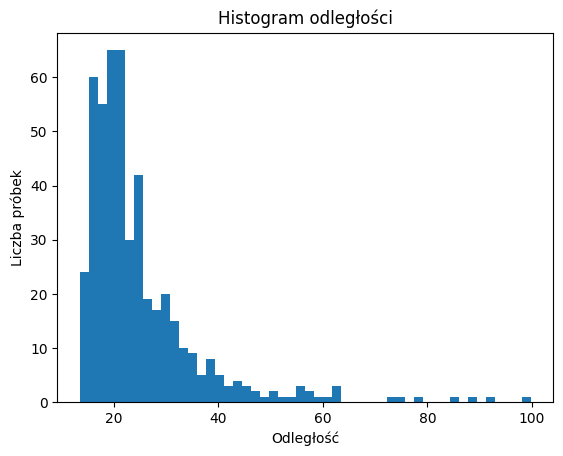

In [156]:
distances = np.sum(X_train_scaled**2, axis=1)**0.5

plt.hist(distances, bins=50)
plt.title('Histogram odległości')
plt.xlabel('Odległość')
plt.ylabel('Liczba próbek')
plt.show()

### Mapa odległości

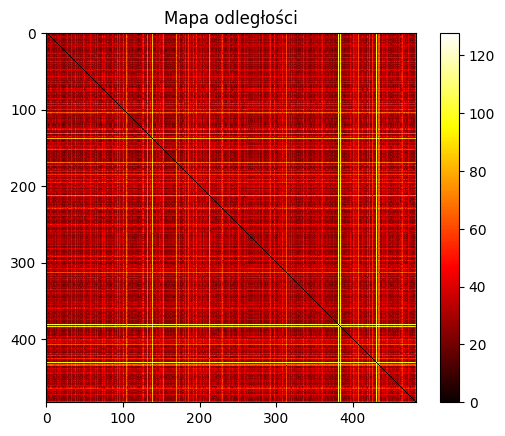

In [157]:
distance_matrix = np.zeros((X_train_scaled.shape[0], X_train_scaled.shape[0]))
for i in range(X_train_scaled.shape[0]):
    for j in range(X_train_scaled.shape[0]):
        distance_matrix[i,j] = np.linalg.norm(X_train_scaled[i] - X_train_scaled[j])

plt.imshow(distance_matrix, cmap='hot', interpolation='nearest')
plt.title('Mapa odległości')
plt.colorbar()
plt.show()

### Wykres TSNE
Na wykresie widać punkty otrzymane redukcji wymiarowości do 2 wymiarów za pomocą t-SNE. Różnymi kolorami zaznaczono 2 klastry wyznaczone metodą KMeans.

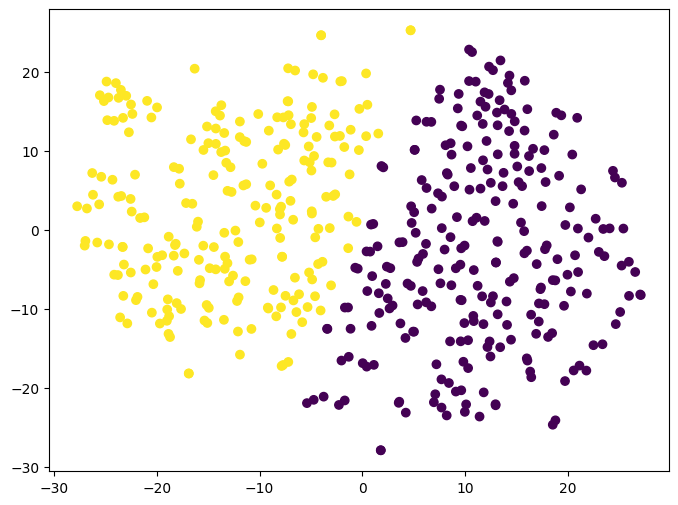

In [158]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_train_scaled)

kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(X_tsne)

plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_labels, cmap='viridis')
plt.show()

## Trening modelu
Użyty model to wielowarstwowa sieć neuronowa MLP.

### Hiperparametry
Do wyznaczenia hiperparametrów został użyty zbiór walidacyjny wielkości 20% zbioru treningowego, na którym zostały porównane 4 modele o różnych ilościach neuronów i warstw ukrytych.

In [166]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

selector = SelectKBest(mutual_info_classif, k=500)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_val_selected = selector.transform(X_val_scaled)
X_test_selected = selector.transform(X_test_scaled)

In [167]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

models = [
    MLPClassifier(hidden_layer_sizes=(1,), max_iter=1000, random_state=42),
    MLPClassifier(hidden_layer_sizes=(10,), max_iter=1000, random_state=42),
    MLPClassifier(hidden_layer_sizes=(50, 20), max_iter=1000, random_state=42),
    MLPClassifier(hidden_layer_sizes=(100, 50, 20), max_iter=1000, random_state=42)
]

results = []
for model in models:
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_val_selected)
    accuracy = accuracy_score(y_val, y_pred)
    results.append(accuracy)

for i, accuracy in enumerate(results, 1):
    print(f"Model {i}: {accuracy:.4f}")

Model 1: 0.8843
Model 2: 0.9256
Model 3: 0.9587
Model 4: 0.9339


Najlepszy wynik osiągnął model 3 - z dwoma warstwami ukrytymi o wielkościach odpowiednio 50 i 20 neuronów.

### Dokładność na zbiorze treningowym

In [159]:
mlp = MLPClassifier(hidden_layer_sizes=(50, 20), max_iter=1000, random_state=42)

mlp.fit(X_train_scaled, y_train)

y_pred = mlp.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print("Dokładność klasyfikacji:", accuracy)

Dokładność klasyfikacji: 0.9078947368421053


### Optymalizacja
Do optymalizacji modelu można wykorzystać metodę usuwania nieistotnych cech. Sprawdzony został także wpływ ilości przykładów na dokładność modelu (dokładność jako funkcja zmniejszającej się liczby przykładów i wzrostu nieistotnych cech).

In [173]:
print("Ilość cech:", len(df.columns))
print("Ilość przykładów:", len(X_train_scaled))

Ilość cech: 754
Ilość przykładów: 483


In [190]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

results = []
features_number_range = [*range(100, 800, 100), 754]
examples_number_range = [*range(100, 500, 100), 483]
examples_number_range.reverse()
ig_threshold = 0.001

for features_number in features_number_range:
    for examples_number in examples_number_range:
        selector = SelectKBest(mutual_info_classif, k=features_number)
        X_train_selected = selector.fit_transform(X_train_scaled, y_train)
        X_test_selected = selector.transform(X_test_scaled)

        ig_values = selector.scores_
        additional_features = np.where(ig_values < ig_threshold)[0]
        X_train_selected = np.concatenate((X_train_selected, X_train_scaled[:, additional_features]), axis=1)
        X_test_selected = np.concatenate((X_test_selected, X_test_scaled[:, additional_features]), axis=1)

        mlp = MLPClassifier(hidden_layer_sizes=(50, 20), max_iter=1000, random_state=42)
        mlp.fit(X_train_selected[:examples_number], y_train[:examples_number])

        y_pred = mlp.predict(X_test_selected)

        accuracy = accuracy_score(y_test, y_pred)
        results.append((features_number, examples_number, accuracy))

results_df = pd.DataFrame(results, columns=['Liczba cech (K)', 'Liczba przykładów', 'Dokładność klasyfikacji'])
print(results_df)

    Liczba cech (K)  Liczba przykładów  Dokładność klasyfikacji
0               100                483                 0.875000
1               100                400                 0.894737
2               100                300                 0.861842
3               100                200                 0.875000
4               100                100                 0.842105
5               200                483                 0.875000
6               200                400                 0.888158
7               200                300                 0.907895
8               200                200                 0.868421
9               200                100                 0.881579
10              300                483                 0.894737
11              300                400                 0.875000
12              300                300                 0.861842
13              300                200                 0.875000
14              300                100  

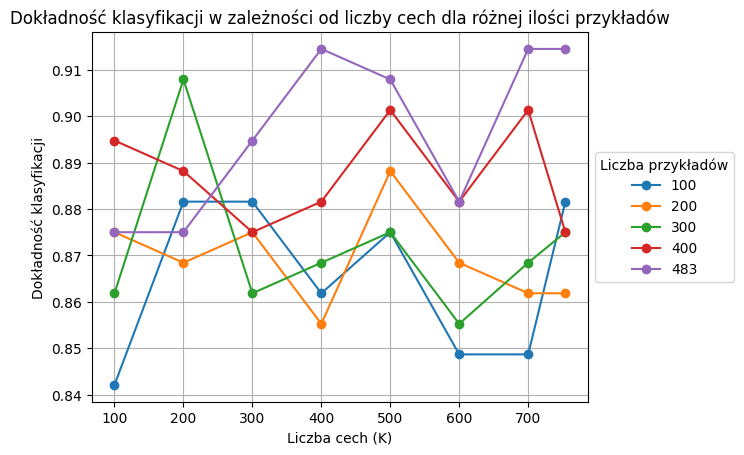

In [191]:
for examples_number in sorted(set(results_df["Liczba przykładów"])):
    subset_df = results_df[results_df["Liczba przykładów"] == examples_number]
    plt.plot(subset_df['Liczba cech (K)'], subset_df['Dokładność klasyfikacji'], marker='o', label=examples_number)
plt.title('Dokładność klasyfikacji w zależności od liczby cech dla różnej ilości przykładów')
plt.xlabel('Liczba cech (K)')
plt.ylabel('Dokładność klasyfikacji')
plt.legend(title='Liczba przykładów', loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()

Liczba przykładów miała pozytywny wpływ na dokładność modelu w większości przypadków - wyjątkiem było $n=300$ osiągające lepszy wynik od $n=400$ i bliskie treningowi na całym zbiorze. Liczba cech osiągała najlepszą wartość w innym miejscu dla różnej ilości przykładów - dla treningu na całym zbiorze najlepsze wyniki dawało $K=400$ oraz $K\in\{700, 754\}$